# Genomic Grammar Analysis

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn

In [3]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [93]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list)
    return sequence_array_list

## Extract Sequence

In [72]:
%%bash
if [ ! -d ./bed_files ]; then mkdir ./bed_files; else rm ./bed_files/*; fi
for peak in ./atac_idr_peaks/*tsv;
do echo $peak;
new_path=${peak/atac_idr_peaks/bed_files};
new_path=${new_path/.tsv/.bed};
echo $new_path;
pos2bed.pl $peak >$new_path
done

./atac_idr_peaks/c57bl6_il4-24h_peaks.tsv
./bed_files/c57bl6_il4-24h_peaks.bed
./atac_idr_peaks/c57bl6_kla-1h_peaks.tsv
./bed_files/c57bl6_kla-1h_peaks.bed
./atac_idr_peaks/c57bl6_veh_peaks.tsv
./bed_files/c57bl6_veh_peaks.bed



	Converted 37096 peaks total


	Converted 31419 peaks total


	Converted 39536 peaks total



In [78]:
%%bash
if [ ! -d ./fasta_files ]; then mkdir ./fasta_files; else rm ./fasta_files/*; fi
for bed_path in ./bed_files/*bed;
do echo $bed_path;
new_path=${bed_path/bed_files/fasta_files};
new_path=${new_path/.bed/.fa};
echo $new_path;
/home/jtao/code/tba/model_training/extract_sequences.py $bed_path mm10 $new_path
done

./bed_files/c57bl6_il4-24h_peaks.bed
./fasta_files/c57bl6_il4-24h_peaks.fa
reading genome mm10
./bed_files/c57bl6_kla-1h_peaks.bed
./fasta_files/c57bl6_kla-1h_peaks.fa
reading genome mm10
./bed_files/c57bl6_veh_peaks.bed
./fasta_files/c57bl6_veh_peaks.fa
reading genome mm10


rm: cannot remove ‘./fasta_files/*’: No such file or directory


## Generate Background Coordinates

In [81]:
%%bash
if [ ! -d ./background_files ]; then mkdir ./background_files; else rm ./background_files/*; fi
for bed_path in ./bed_files/*bed;
do echo $bed_path;
echo /home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_path ./background_files -genome mm10
done

./bed_files/c57bl6_il4-24h_peaks.bed
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_il4-24h_peaks.bed ./background_files -genome mm10
./bed_files/c57bl6_kla-1h_peaks.bed
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_kla-1h_peaks.bed ./background_files -genome mm10
./bed_files/c57bl6_veh_peaks.bed
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_veh_peaks.bed ./background_files -genome mm10


rm: cannot remove ‘./background_files/*’: No such file or directory


In [88]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background_files/ ]; then mkdir ./background_files/ ; fi
for i in ./bed_files/*bed;
do 
    factor=${i##*/};
    factor=${factor%.bed};
    fasta_path="./background_files/${factor}_background.fasta"
    bed_path="./background_files/${factor}_background.bed"

    echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $i ./background_files/ -genome mm10" >> $script_path;
    echo "mv ./background_files/background.bed $bed_path" >> $script_path;
    echo "mv ./background_files/background.fasta $fasta_path" >> $script_path;
done

In [ ]:
%%bash
rm ./background/*
chmod a+x ./*sh
bash ./make_background.sh

## Read in Data

In [232]:
positive_seqRecords = list(SeqIO.parse('./fasta_files/c57bl6_il4-24h_peaks.fa', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_il4-24h_peaks_background.fasta', 'fasta'))

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)


x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)


In [233]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Count Params

In [234]:
def count_num_params(seq_size,
                     num_motifs, 
                     motif_size,
                     adjacent_bp_pool_size,
                     attention_dim,
                     attention_hops,
                     num_dense_neurons
                    ):
    total_params = 0
    
    # convolution layer
    convolution_params = num_motifs * motif_size * 4
    total_params += convolution_params
    print('Convolution Params:', convolution_params)
    
    # lstm layer
    # account for pooling
    lstm_input_size = num_motifs
    # account for reverse complement sequence
    lstm_input_size = lstm_input_size * 2
    
    num_lstm_neurons = seq_size/ adjacent_bp_pool_size
    
    lstm_params = lstm_input_size * 4 * num_lstm_neurons
    # account for bidrectional lstm
    lstm_params = lstm_params * 2
    
    total_params += lstm_params
    print('LSTM Params:', lstm_params)
    
    # attention layer
    # first layer of perceptron
    attention_params = attention_dim * (seq_size/adjacent_bp_pool_size*2) 
    # account for hops of attention (second layer of perceptron)
    attention_params += attention_dim * attention_hops
    
    total_params += attention_params
    print('Attention Params:', attention_params)
    
    # dense layer
    dense_params = lstm_input_size * num_dense_neurons
    total_params += dense_params
    print('Dense Params:', dense_params)
    
    return total_params

In [101]:
seq_size = 150
num_classes = 2
num_motifs = 20
motif_size = 20
adjacent_bp_pool_size = 1
attention_dim = 50 # 350 from A Structured Self-attentive Sentence Embedding
attention_hops = 1 # from A Structured Self-attentive Sentence Embedding
num_dense_neurons = 100 # 2-layer, 2000 units, from A Structured Self-attentive Sentence Embedding

count_num_params(seq_size,
    num_motifs, 
    motif_size,
    adjacent_bp_pool_size,
    attention_dim,
    attention_hops,
    num_dense_neurons
    )

Convolution Params: 1600
LSTM Params: 48000.0
Attention Params: 15050.0
Dense Params: 4000


68650.0

## Define Model

In [265]:
seq_size = 150
num_classes = 2
num_motifs = 20
motif_size = 20
adjacent_bp_pool_size = 1
attention_dim = 50 
attention_hops = 1 
num_dense_neurons = 100 

### Top Motif Scores

In [266]:
total_seq_length = len(fasta_seq[0])

input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
input_rev = Input(shape=(total_seq_length,4), name='input_rev')

# find motifs
convolution_layer = Conv1D(filters=num_motifs, 
    kernel_size=motif_size,
    activation='relu',
    input_shape=(total_seq_length,4),
    name='convolution_layer',
    padding = 'same'
    )
forward_motif_scores = convolution_layer(input_fwd)
reverse_motif_scores = convolution_layer(input_rev)
print('forward_motif_scores', forward_motif_scores.shape)

# crop motif scores to avoid parts of sequence where motif score is computed in only one direction
to_crop = int((total_seq_length - seq_size)/2)
crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
    name='crop_layer')
cropped_fwd_scores = crop_layer(forward_motif_scores)
cropped_rev_scores = crop_layer(reverse_motif_scores)
print('cropped_fwd_scores', cropped_fwd_scores.shape)

# # flip motif scores
# flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
#     output_shape=(seq_size, num_motifs),
#     name='flip_layer')
# flipped_rev_scores = flip_layer(cropped_rev_scores)
# print('flipped_rev_scores', flipped_rev_scores.shape)

# calculate max scores for each orientation
seq_pool_layer = MaxPool1D(pool_size=seq_size)
max_fwd_scores = seq_pool_layer(cropped_fwd_scores)
max_rev_scores = seq_pool_layer(cropped_rev_scores)
print('max_fwd_scores', max_fwd_scores.shape)

# calculate max score for strand
orientation_max_layer = Maximum()
max_seq_scores = orientation_max_layer([max_fwd_scores, max_rev_scores])
print('max_seq_scores', max_seq_scores.shape)

# fully connected layer
dense_out = Dense(32, activation='relu', 
                 )(max_seq_scores)

# drop out
drop_out = Dropout(0.25)(dense_out)

# make prediction
flattened = Flatten()(drop_out)
predictions = Dense(num_classes,
                    activation = 'softmax', 
                   )(flattened)

forward_motif_scores (?, 200, 20)
cropped_fwd_scores (?, 150, 20)
max_fwd_scores (?, 1, 20)
max_seq_scores (?, 1, 20)


In [267]:
# define and compile model
convolution_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

convolution_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [270]:
convolution_model.fit([x_train, x_rc_train], y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = convolution_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 59352 samples, validate on 14838 samples
Epoch 1/10
59352/59352 [==============================] - 9s - loss: 0.3703 - acc: 0.8381 - val_loss: 0.3683 - val_acc: 0.8370
Epoch 2/10
59352/59352 [==============================] - 9s - loss: 0.3694 - acc: 0.8380 - val_loss: 0.3755 - val_acc: 0.8305
Epoch 3/10
59352/59352 [==============================] - 9s - loss: 0.3676 - acc: 0.8381 - val_loss: 0.3692 - val_acc: 0.8356
Epoch 4/10
59352/59352 [==============================] - 9s - loss: 0.3660 - acc: 0.8405 - val_loss: 0.3684 - val_acc: 0.8355
Epoch 5/10
59352/59352 [==============================] - 9s - loss: 0.3639 - acc: 0.8422 - val_loss: 0.3665 - val_acc: 0.8384
Epoch 6/10
59352/59352 [==============================] - 9s - loss: 0.3632 - acc: 0.8424 - val_loss: 0.3643 - val_acc: 0.8384
Epoch 7/10
59352/59352 [==============================] - 9s - loss: 0.3605 - acc: 0.8442 - val_loss: 0.3697 - val_acc: 0.8358
Epoch 8/10
59352/59352 [==============================] - 9s 

In [271]:
probs = convolution_model.predict([x_test, x_rc_test])

sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )

0.918505383744855

### LSTM Model

In [280]:
seq_size = 150
num_classes = 2
num_motifs = 20
motif_size = 20
adjacent_bp_pool_size = 1
attention_dim = 50 
attention_hops = 1 
num_dense_neurons = 100 

In [281]:
total_seq_length = len(fasta_seq[0])

input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
input_rev = Input(shape=(total_seq_length,4), name='input_rev')

# find motifs
convolution_layer = Conv1D(filters=num_motifs, 
    kernel_size=motif_size,
    activation='relu',
    input_shape=(total_seq_length,4),
    name='convolution_layer',
    padding = 'same'
    )
forward_motif_scores = convolution_layer(input_fwd)
reverse_motif_scores = convolution_layer(input_rev)
print('forward_motif_scores', forward_motif_scores.shape)

# crop motif scores to avoid parts of sequence where motif score is computed in only one direction
to_crop = int((total_seq_length - seq_size)/2)
crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
    name='crop_layer')
cropped_fwd_scores = crop_layer(forward_motif_scores)
cropped_rev_scores = crop_layer(reverse_motif_scores)
print('cropped_fwd_scores', cropped_fwd_scores.shape)

# flip motif scores
flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
    output_shape=(seq_size, num_motifs),
    name='flip_layer')
flipped_rev_scores = flip_layer(cropped_rev_scores)
print('flipped_rev_scores', flipped_rev_scores.shape)

# concatenate motif scores
concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
print('concatenated_motif_scores', concatenated_motif_scores.shape)

# pool across length of sequence
sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
    strides=adjacent_bp_pool_size,
    name='sequence_pooling_layer')
pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
print('pooled_scores', pooled_scores.shape)

forward_motif_scores (?, 200, 20)
cropped_fwd_scores (?, 150, 20)
flipped_rev_scores (?, 150, 20)
concatenated_motif_scores (?, 150, 40)
pooled_scores (?, 150, 40)


## Visualize Model

In [4]:
from keras.layers import Bidirectional

from keras.layers import LSTM

from keras.layers import Activation

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                        input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

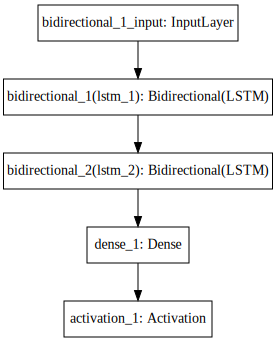

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))